In [1]:
from pandas_datareader import data as web
import numpy as np
import pandas as pd
from sklearn import mixture as mix
import seaborn as sns 
import matplotlib.pyplot as plt

### 1. Loading Data

In [2]:
df= web.get_data_yahoo('SPY',start= '2000-01-01', end='2020-12-31')
df=df[['Open','High','Low', 'Adj Close']]

### 2. Detecting Regimes

In [3]:
regime_detector = mix.GaussianMixture(n_components=4, 
                            covariance_type="spherical", 
                            n_init=100, 
                            random_state=14)

In [4]:
regime_detector.fit(np.reshape(df, (-1, df.shape[1])))
regime = regime_detector.predict(np.reshape(df, (-1, df.shape[1])))

In [5]:
df['Return']= np.log(df['Adj Close'] / df['Adj Close'].shift(1))

In [6]:
regimes = pd.DataFrame(regime, columns=['Regime'],index=df.index)
regimes = regimes.join(df, how='inner')
regimes['Cumulative Return of U.S. Market'] = df.Return.cumsum()
regimes = regimes.reset_index(drop=False)
regimes = regimes.rename(columns={'index':'Date'})
regimes = regimes.iloc[1:, ]

In [7]:
regimes.head()

,Date,Regime,Open,High,Low,Adj Close,Return,Cumulative Return of U.S. Market
1,2000-01-03,0,148.25000,148.25000,143.875000,97.825676,-0.009836,-0.009836
2,2000-01-04,0,143.53125,144.06250,139.640625,94.000107,-0.039891,-0.049727
3,2000-01-05,0,139.93750,141.53125,137.250000,94.168259,0.001787,-0.047940
4,2000-01-06,0,139.62500,141.50000,137.750000,92.654861,-0.016202,-0.064141
5,2000-01-07,0,140.31250,145.75000,140.062500,98.035896,0.056452,-0.007689


### 3. Plotting and Analyzing Regimes

/home/fedebotu/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


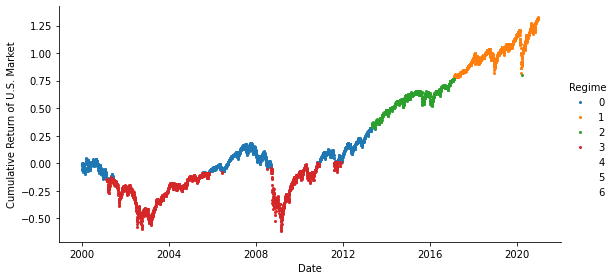

In [63]:
order=[0,1,2,3,4,5,6]
fig = sns.FacetGrid(data= regimes,hue='Regime',hue_order=order,aspect=2,size= 4)
fig.map(plt.scatter,'Date', 'Cumulative Return of U.S. Market', s=4).add_legend()
plt.savefig('images/market_gaussian.pdf', bbox_inches='tight')
plt.show()

In [9]:
print(order)

[0, 1, 2, 3, 4, 5, 6]


In [10]:
for i in order:
    if i > 3: break
    mean = round(regime_detector.means_[i][0], 4)
    cov = round(regime_detector.covariances_[i], 4)
    print('- Mean for Regime %i: '%i,mean)
    print('> Covariance for Regime %i: '%i, cov)

- Mean for Regime 0:  137.5967
> Covariance for Regime 0:  89.7873
- Mean for Regime 1:  284.536
> Covariance for Regime 1:  1148.4455
- Mean for Regime 2:  197.8587
> Covariance for Regime 2:  298.8313
- Mean for Regime 3:  106.826
> Covariance for Regime 3:  142.6559


## 4. Detecting the Market Regime using Hidden Markov Models

We assume the system to be
Reference: [Here](https://www.quantstart.com/articles/market-regime-detection-using-hidden-markov-models-in-qstrader/)


In [53]:
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
from matplotlib.ticker import MaxNLocator
from hmmlearn.hmm import GaussianHMM

df= web.get_data_yahoo('SPY',start= '2000-01-01', end='2020-12-31')
df=df[['Open','High','Low', 'Adj Close']]

returns = np.column_stack([df['Adj Close']])

In [54]:
hmm_model = GaussianHMM(
    n_components=4, covariance_type="full", n_iter=1000
).fit(returns)
print("Model Score:", hmm_model.score(returns))

Model Score: -21414.19798132809


In [65]:
def plot_hidden_states(hmm_model, df, data, 
                       figsize=(10,10), 
                       year_loc=True, 
                       month_loc=False,
                       max_tickers=10):
    """
    Plot the adjusted closing prices masked by 
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    hidden_states = hmm_model.predict(data)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components, 
        sharex=True, sharey=True,
        figsize=figsize
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    fig.autofmt_xdate()

    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask], 
            df["Adj Close"][mask], 
            ".", linestyle='none', 
            c=colour
        )
        ax.set_title("Hidden State #%s" % i)
        if year_loc: ax.xaxis.set_major_locator(YearLocator())
        if month_loc: ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)

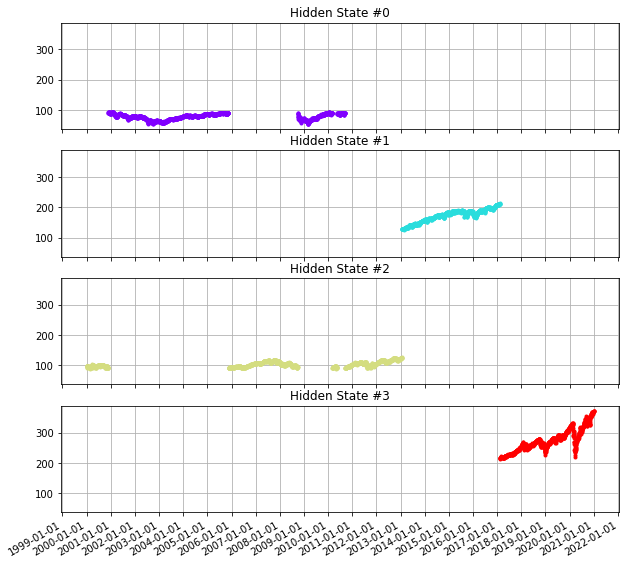

In [66]:
plot_hidden_states(hmm_model, df, returns, figsize=(10,10), year_loc=True, month_loc=False, max_tickers=7)
plt.savefig('images/hidden_markov.pdf', bbox_inches='tight')